# Cellular Metabolism Research
### Spring 2019                            Danhui Zhang

This project is done partly to support the competitor & market research for REDOX. REDOX is a lab services company that uses novel imaging techniques to provide scientists in pharmaceutical companies with unprecedented subcellular-level metabolic information to help understand drug-cellular interactions and thereby aiding the drug discovery and development process and reducing wasted resources. Through analyzing three optical biomarkers - cellular redox state, bound NADH fraction, and mitochondrial clustering - we are able to provide information on the metabolic activity happening within the cells. Currently we are capable of providing insights into specific metabolic pathways, including glycolysis, glutaminolysis, mitochondrial uncoupling, fatty acid oxidation, and fatty acid synthesis, with single-cell resolution.

Though our previous understanding was that the pharmaceutical industry currently only measures the level of metabolites in cells or bulk metrics and does not measure cell-differentiated metabolic activity, our recent research and interviews reveal that some companies are looking into specific metabolic pathways which overlap with our service offerings. As the field of measuring metabolic activity in drug research is still in its nascent stage, specific disease models that work well with our product are not yet validated. Therefore, through looking into applications of our competitor’s products (published in scientific journals), our team may find drug research of specific disease types/cell lines that may serve our beachhead market. The dataset used in this project is found on Agilent Cell Reference Database:
https://www.agilent.com/cell-reference-database/

### Why is looking into cellular metabolism-related research important?
* Use case 1: The MYC oncogene is frequently mutated and overexpressed in human renal cell carcinoma (RCC). Research shows that MYC-induced RCC up-regulated the glutaminolytic pathway instead of the glycolytic pathway. The pharmacologic inhibition of glutamine metabolism with bis-2-(5-phenylacetamido-1,2,4-thiadiazol-2-yl) ethyl sulfide impeded MYC-mediated tumor progression. Thus, the inhibition of glutamine metabolism is a potential therapeutic approach for the treatment of this disease. (Shroff et al. PNAS 2015)
* Use case 2: Insights into tumor cellular metabolism upon administration of therapeutics can serve as an early predictor of *in vivo* tumor drug response. In the current standard of care, patients with innate drug resistance are not identified *a priori* and drug effectiveness is determined after weeks of treatment from tumor size measurements using mammography, MRI, or ultrasound. Research showed that observations of cellular metabolic changes can predict tumor drug response much earlier than the traditional imaging methods, at about 72 hours after administration. (Walsh et al. 2014)

Learning about more use cases like the aforementioned research areas can help REDOX better navigate the current research landscape and gain an in-depth understanding of current methods used to measure cellular metabolism. With this knowledge, REDOX can hope to best position itself in the market with its differentiating features.



In [335]:
import pandas as pd
import numpy as np
import re

# Generate Word Cloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Fuzzy matching
from fuzzywuzzy import fuzz, process

In [336]:
data = pd.read_csv('./CellLineInput_or.csv')
data.head()

,Title,Authors,Journal,Publication date,Research area,Cell Line,Cell Type,Species,Analyzer,XF Assay,Plate Reader Assay,Seeding density,Plate coating
0,_-1-Antitrypsin (AAT)-modified donor cells sup...,"Marcondes AM, Karoopongse E, Lesnikova M, Marg...",Blood,Oct 1 2014 12:00 AM,Immunology Research,T-cells,T-cells,Mouse,24,Cell Mitochondrial Stress Test,NaN,8.0x10^5 cells/well,Not Specified
1,_-1-Antitrypsin (AAT)-modified donor cells sup...,"Marcondes AM, Karoopongse E, Lesnikova M, Marg...",Blood,Oct 1 2014 12:00 AM,Immunology Research,Natural Killer (NK) cells,Immune Cells,Mouse,24,Cell Mitochondrial Stress Test,NaN,8.0x10^5 cells/well,Not Specified
2,_-enolase regulates the malignant phenotype of...,"J. Dai, Q. Zhou, J. Chen, M. L. Rexius-Hall, J...",Nat Commun,Sep 21 2018 12:00 AM,Cell Physiology Research,Pulmonary Artery Smooth Muscle Cells (PASMC),Pulmonary Artery Cells,Human,24,Cell Mitochondrial Stress Test,NaN,3.0 x10^4 cells/well,Not Specified
3,_-enolase regulates the malignant phenotype of...,"J. Dai, Q. Zhou, J. Chen, M. L. Rexius-Hall, J...",Nat Commun,Sep 21 2018 12:00 AM,Cell Physiology Research,Pulmonary Artery Smooth Muscle Cells (PASMC),Pulmonary Artery Cells,Human,24,Glycolysis Stress Test,NaN,3.0 x10^4 cells/well,Not Specified
4,_-ketoglutarate orchestrates macrophage activa...,"P. S. Liu, H. Wang, X. Li, T. Chao, T. Teav, S...",Nat Immunol,Sep 1 2017 12:00 AM,Immunology Research,Bone Marrow-Derived Macrophages (BMDM),Immune Cells,Mouse,96,Cell Mitochondrial Stress Test,NaN,1.0 x10^5 cells/well,Not Specified


In [337]:
rows = len(data.index)
print ('Number of rows in the table: ', rows)

Number of rows in the table:  9634


### Issues identified:
* Publication dates all ends with "12:00 AM", not particularly meaningful
* Seeding density are in scientific notations + units, cannot be directly read

In [338]:
# dropping null value columns to avoid errors 
# data.dropna(inplace = True) 
# data = data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9634 entries, 0 to 9633
Data columns (total 13 columns):
Title                 9634 non-null object
Authors               9632 non-null object
Journal               9596 non-null object
Publication date      9628 non-null object
Research area         9634 non-null object
Cell Line             9620 non-null object
Cell Type             9626 non-null object
Species               9562 non-null object
Analyzer              9615 non-null object
XF Assay              9232 non-null object
Plate Reader Assay    345 non-null object
Seeding density       9579 non-null object
Plate coating         9581 non-null object
dtypes: object(13)
memory usage: 978.5+ KB


## Merge Datasets

Original dataset and journal impact factor dataset are merged in this section

In [339]:
data.columns

Index(['Title', 'Authors', 'Journal', 'Publication date', 'Research area',
       'Cell Line', 'Cell Type', 'Species', 'Analyzer', 'XF Assay',
       'Plate Reader Assay', 'Seeding density', 'Plate coating'],
      dtype='object')

In [340]:
# find number unique instances in each column
[len(data[c].value_counts()) for c in data.columns]

[4306, 4303, 850, 659, 26, 1134, 220, 64, 9, 19, 4, 529, 69]

In [341]:
data['Epoch'] = pd.to_datetime(data['Publication date']).astype('int64')
data.head()

,Title,Authors,Journal,Publication date,Research area,Cell Line,Cell Type,Species,Analyzer,XF Assay,Plate Reader Assay,Seeding density,Plate coating,Epoch
0,_-1-Antitrypsin (AAT)-modified donor cells sup...,"Marcondes AM, Karoopongse E, Lesnikova M, Marg...",Blood,Oct 1 2014 12:00 AM,Immunology Research,T-cells,T-cells,Mouse,24,Cell Mitochondrial Stress Test,NaN,8.0x10^5 cells/well,Not Specified,1412121600000000000
1,_-1-Antitrypsin (AAT)-modified donor cells sup...,"Marcondes AM, Karoopongse E, Lesnikova M, Marg...",Blood,Oct 1 2014 12:00 AM,Immunology Research,Natural Killer (NK) cells,Immune Cells,Mouse,24,Cell Mitochondrial Stress Test,NaN,8.0x10^5 cells/well,Not Specified,1412121600000000000
2,_-enolase regulates the malignant phenotype of...,"J. Dai, Q. Zhou, J. Chen, M. L. Rexius-Hall, J...",Nat Commun,Sep 21 2018 12:00 AM,Cell Physiology Research,Pulmonary Artery Smooth Muscle Cells (PASMC),Pulmonary Artery Cells,Human,24,Cell Mitochondrial Stress Test,NaN,3.0 x10^4 cells/well,Not Specified,1537488000000000000
3,_-enolase regulates the malignant phenotype of...,"J. Dai, Q. Zhou, J. Chen, M. L. Rexius-Hall, J...",Nat Commun,Sep 21 2018 12:00 AM,Cell Physiology Research,Pulmonary Artery Smooth Muscle Cells (PASMC),Pulmonary Artery Cells,Human,24,Glycolysis Stress Test,NaN,3.0 x10^4 cells/well,Not Specified,1537488000000000000
4,_-ketoglutarate orchestrates macrophage activa...,"P. S. Liu, H. Wang, X. Li, T. Chao, T. Teav, S...",Nat Immunol,Sep 1 2017 12:00 AM,Immunology Research,Bone Marrow-Derived Macrophages (BMDM),Immune Cells,Mouse,96,Cell Mitochondrial Stress Test,NaN,1.0 x10^5 cells/well,Not Specified,1504224000000000000


In [342]:
data['Title'].iloc[1] == data['Title'].iloc[0]

True

In [343]:
len(data)

9634

In [344]:
# # Make dictionary for matching rows
# for i in len(data)
    

Read the dataset that contains impact factors of biochemistry, genetics and molecular biology journals.

In [345]:
# journal_impact = pd.read_csv('https://www.scimagojr.com/journalrank.php?area=1300&out=xls', sep=';')
journal_impact = pd.read_csv('./Impact_bio.csv', sep=';')
journal_impact.head()

,Rank,Sourceid,Title,Type,Issn,SJR,SJR Best Quartile,H index,Total Docs. (2017),Total Docs. (3years),Total Refs.,Total Cites (3years),Citable Docs. (3years),Cites / Doc. (2years),Ref. / Doc.,Country,Publisher,Categories
0,1,18991,Nature Reviews Genetics,journal,"14710056, 14710064","34,896",Q1,307,108,429,7108,7296,167,"38,94","65,81",United Kingdom,Nature Publishing Group,Genetics (Q1); Genetics (clinical) (Q1); Molec...
1,2,20315,Nature Reviews Molecular Cell Biology,journal,"14710072, 14710080","32,714",Q1,372,112,428,7278,8741,206,"29,64","64,98",United Kingdom,Nature Publishing Group,Cell Biology (Q1); Molecular Biology (Q1)
2,3,18434,Cell,journal,"00928674, 10974172","25,137",Q1,682,547,1978,27123,43114,1734,"23,61","49,59",United States,Cell Press,"Biochemistry, Genetics and Molecular Biology (..."
3,4,12464,Nature Reviews Cancer,journal,1474175X,"23,530",Q1,373,118,403,9157,7687,198,"37,90","77,60",United Kingdom,Nature Publishing Group,Cancer Research (Q1); Oncology (Q1)
4,5,18990,Nature Genetics,journal,10614036,"22,243",Q1,511,291,811,13028,16977,693,"22,68","44,77",United Kingdom,Nature Publishing Group,Genetics (Q1)


In [346]:
# Only keep columns we need
journal_impact = journal_impact[['Title','SJR','H index']]
journal_impact.head()

,Title,SJR,H index
0,Nature Reviews Genetics,"34,896",307
1,Nature Reviews Molecular Cell Biology,"32,714",372
2,Cell,"25,137",682
3,Nature Reviews Cancer,"23,530",373
4,Nature Genetics,"22,243",511


Here both SJR and H index are kept for future references. These are both measures of the quality of a journal. H index does not take into account differing citation practices of fields (unlike the weighted SJR) and so is best used to compare journals within a field.

Now the merge begins!  
  
First we create a two-column dataset that contains identical journal names in both columns.  
The first 850 rows come from the 850 unique journal values from the original dataset.  
Then, the journal titles from the impact factor dataset are appended.  
  
The purpose of using both 'Original' and 'Fuzzy' columns is to use OpenRefine to cluster & merge 'Fuzzy' column values, while the 'Original' column keeps the reference to respective initial dataset.

In [347]:
# Create new empty dataframe
fuzzy_match = pd.DataFrame(columns=['Original', 'Fuzzy'])

# Populate df with unique original journal titles
fuzzy_match.Original = data.Journal.unique()
fuzzy_match.Fuzzy = data.Journal.unique()

# Create new df to populate with journal_impact titles
df2 = pd.DataFrame(columns=['Original', 'Fuzzy'])
df2.Original = journal_impact.Title
df2.Fuzzy = journal_impact.Title

# Append the second df to the end of the one with original titles
fuzzy_match = fuzzy_match.append(df2, ignore_index = True)

# Show row 850 & 851 where both datasets are connected together
fuzzy_match.iloc[845:855]

,Original,Fuzzy
845,Benef Microbes,Benef Microbes
846,Hepatol Commun,Hepatol Commun
847,Chem Rev,Chem Rev
848,Life Science Alliance,Life Science Alliance
849,Blood Cancer J,Blood Cancer J
850,BIOspektrum,BIOspektrum
851,Nature Reviews Genetics,Nature Reviews Genetics
852,Nature Reviews Molecular Cell Biology,Nature Reviews Molecular Cell Biology
853,Cell,Cell
854,Nature Reviews Cancer,Nature Reviews Cancer


In [348]:
fuzzy_match.to_csv(r'./Fuzzy_preOR.csv',index=False)

After we check that the dataset is appended correctly, we export this dataset as 'Fuzzy_preOR.csv' for **clustering & merging in OpenRefine**.  

OpenRefine does a great job at merging journal titles that look similar. The result is exported as 'Fuzzy_postOR.csv', **an intermediary dataset** used to merge our original datasets.  

**How is the merging process carried out?**
* The intermediary dataset is cut into two segments. Each segment contains 
    * column 0 - reference journal titles, same as those shown in its original dataset
    * column 1 - OpenRefine-clustered & merged journal titles, used for the last merge
* Each segment of the intermediary dataset is left-joined with its original dataset. Now, both datasets have an additional column, "Fuzzy", which serves as the connector for the last merge
* **The Last Merge**: both original dataset & journal impact factor dataset are left-joined through the "Fuzzy" column

<img src="./img/merge_graphic.png" width="680">

In [349]:
fuzzy_postOR = pd.read_csv('./Fuzzy_postOR.csv')
fuzzy_postOR = fuzzy_postOR[['Original','Fuzzy']]

fuzzy_postOR_Original = pd.DataFrame(columns=['Journal', 'Fuzzy'])
fuzzy_postOR_Original.Journal = fuzzy_postOR.iloc[:850, 0]
fuzzy_postOR_Original.Fuzzy = fuzzy_postOR.iloc[:850, 1]
data_fuzzy = data.merge(fuzzy_postOR_Original, how='left', on='Journal', suffixes=('_x','_y'))
# data_fuzzy

fuzzy_postOR_Impact = pd.DataFrame(columns=['Title', 'Fuzzy'])
fuzzy_postOR_Impact.Title = fuzzy_postOR.iloc[850:, 0]
fuzzy_postOR_Impact.Fuzzy = fuzzy_postOR.iloc[850:, 1]
impact_fuzzy = journal_impact.merge(fuzzy_postOR_Impact, how='left', on='Title', suffixes=('_x','_y'))
impact_fuzzy = impact_fuzzy.drop(columns='Title')
# impact_fuzzy

df = data_fuzzy.merge(impact_fuzzy, how='left', on='Fuzzy', suffixes=('_x','_y'))
df = df.drop(columns=['Publication date','Fuzzy'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9634 entries, 0 to 9633
Data columns (total 15 columns):
Title                 9634 non-null object
Authors               9632 non-null object
Journal               9596 non-null object
Research area         9634 non-null object
Cell Line             9620 non-null object
Cell Type             9626 non-null object
Species               9562 non-null object
Analyzer              9615 non-null object
XF Assay              9232 non-null object
Plate Reader Assay    345 non-null object
Seeding density       9579 non-null object
Plate coating         9581 non-null object
Epoch                 9634 non-null int64
SJR                   1697 non-null object
H index               1701 non-null float64
dtypes: float64(1), int64(1), object(13)
memory usage: 1.2+ MB


,Title,Authors,Journal,Research area,Cell Line,Cell Type,Species,Analyzer,XF Assay,Plate Reader Assay,Seeding density,Plate coating,Epoch,SJR,H index
0,_-1-Antitrypsin (AAT)-modified donor cells sup...,"Marcondes AM, Karoopongse E, Lesnikova M, Marg...",Blood,Immunology Research,T-cells,T-cells,Mouse,24,Cell Mitochondrial Stress Test,NaN,8.0x10^5 cells/well,Not Specified,1412121600000000000,"6,434",410.0
1,_-1-Antitrypsin (AAT)-modified donor cells sup...,"Marcondes AM, Karoopongse E, Lesnikova M, Marg...",Blood,Immunology Research,Natural Killer (NK) cells,Immune Cells,Mouse,24,Cell Mitochondrial Stress Test,NaN,8.0x10^5 cells/well,Not Specified,1412121600000000000,"6,434",410.0
2,_-enolase regulates the malignant phenotype of...,"J. Dai, Q. Zhou, J. Chen, M. L. Rexius-Hall, J...",Nat Commun,Cell Physiology Research,Pulmonary Artery Smooth Muscle Cells (PASMC),Pulmonary Artery Cells,Human,24,Cell Mitochondrial Stress Test,NaN,3.0 x10^4 cells/well,Not Specified,1537488000000000000,NaN,NaN
3,_-enolase regulates the malignant phenotype of...,"J. Dai, Q. Zhou, J. Chen, M. L. Rexius-Hall, J...",Nat Commun,Cell Physiology Research,Pulmonary Artery Smooth Muscle Cells (PASMC),Pulmonary Artery Cells,Human,24,Glycolysis Stress Test,NaN,3.0 x10^4 cells/well,Not Specified,1537488000000000000,NaN,NaN
4,_-ketoglutarate orchestrates macrophage activa...,"P. S. Liu, H. Wang, X. Li, T. Chao, T. Teav, S...",Nat Immunol,Immunology Research,Bone Marrow-Derived Macrophages (BMDM),Immune Cells,Mouse,96,Cell Mitochondrial Stress Test,NaN,1.0 x10^5 cells/well,Not Specified,1504224000000000000,NaN,NaN


Text(0, 0.5, 'Percent Missing')

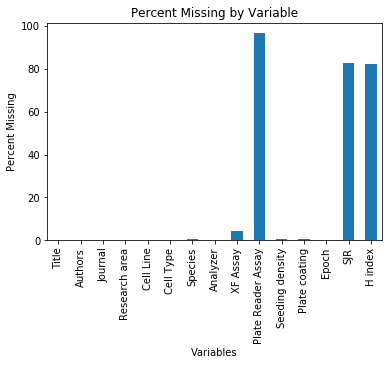

In [350]:
((df.isnull().sum()/len(data)) * 100).plot(kind='bar')

# Add title, x- and y- axes labels
plt.title('Percent Missing by Variable')
plt.xlabel("Variables")
plt.ylabel("Percent Missing")

## Data Cleaning

In [351]:
df['Seeding density'].iloc[410:429]

410           Not Specified
411           Not Specified
412           Not Specified
413           Not Specified
414           Not Specified
415           Not Specified
416    2.0 x10^4 cells/well
417    0.15x10^6 cells/well
418     1.0x10^4 cells/well
419     1.0x10^4 cells/well
420           Not Specified
421           Not Specified
422              50 ug/well
423              50 ug/well
424    8.0 x10^4 cells/well
425    8.0 x10^4 cells/well
426           Not Specified
427     8.0x10^2 cells/well
428    4.0 x10^4 cells/well
Name: Seeding density, dtype: object

In [352]:
# split on the space
# temp = df['Seeding density'][1].split(' ')[-1]
df['Seeding density'] = df['Seeding density'].astype(str)
df['Seeding density unit'] = df['Seeding density'].apply(lambda x: x.split(' ')[-1])
df['Seeding density unit'].value_counts()[:10]
# len(df['Seeding density unit'].unique())
# take the last one
# see how many unique
# extract the numbers by spliting on x and ^

cells/well      5215
Specified       3774
ug/well          177
nan               55
worms/well        50
islets/well       40
protein/well      32
cells/mL          21
well              19
cell/well         16
Name: Seeding density unit, dtype: int64

In [353]:
fuzz.partial_ratio('cells/well', 'cells/welll')

100

In [354]:
fuzz.token_set_ratio('cells/well', 'cell/swell')

90

In [355]:
# # Replace units with correct spelling
# df['Seeding density unit'].replace('cells/welll', 'cells/well', inplace=True)
# df['Seeding density unit'].replace('cell/swell', 'cells/well', inplace=True)
# df['Seeding density unit'].replace('cell/well', 'cells/well', inplace=True)
# df['Seeding density unit'].replace('cells/wll', 'cells/well', inplace=True)
# df['Seeding density unit'].value_counts()
# len(df['Seeding density unit'].unique())
# Let's see whether there is a faster way to do this

In [356]:
choices = df['Seeding density unit'].unique()
possibilities = process.extract('cells/well', choices, limit=10, scorer=fuzz.token_sort_ratio)
# Let's see everyting with a score above 88
# Reference: http://jonathansoma.com/lede/algorithms-2017/classes/fuzziness-matplotlib/fuzzing-matching-in-pandas-with-fuzzywuzzy/
[possible for possible in possibilities if possible[1] > 88]

[('cells/well', 100),
 ('cell/well', 95),
 ('cells/welll', 95),
 ('cells/wll', 95),
 ('cell/swell', 90)]

In [357]:
choices = df['Seeding density unit'].unique()
possibilities = process.extract('Specified', choices, limit=10, scorer=fuzz.ratio)
[possible for possible in possibilities if possible[1] > 88]

[('Specified', 100),
 ('Speccified', 95),
 ('Specifed', 94),
 ('Sepcified', 89),
 ('Speciifed', 89)]

In [358]:
# df.apply(lambda row: fuzz.token_sort_ratio(row['Seeding density unit'], 'cells/well'), axis=1) > 88
df.loc[df.apply(lambda row: fuzz.token_sort_ratio(row['Seeding density unit'], 'cells/well'), axis=1) > 88,\
       'Seeding density unit'] = 'cells/well'

# Check that fuzzy match worked
len(df['Seeding density unit'].unique())

90

In [359]:
df.loc[df.apply(lambda row: fuzz.token_sort_ratio(row['Seeding density unit'], 'Specified'), axis=1) > 88,\
       'Seeding density unit'] = 'Specified'

# Check that fuzzy match worked
len(df['Seeding density unit'].unique())

86

In [360]:
df.loc[df.apply(lambda row: fuzz.token_sort_ratio(row['Seeding density unit'], 'ug/well'), axis=1) > 88,\
       'Seeding density unit'] = 'ug/well'

# Check that fuzzy match worked
len(df['Seeding density unit'].unique())

85

In [361]:
cells_well = df.apply(lambda row: fuzz.token_sort_ratio(row['Seeding density unit'], 'cells/well'), axis=1) > 88
cells_well_dict = cells_well.value_counts().to_dict()
print('"cells/well" counts: ', cells_well_dict.get(True))

not_specified = df.apply(lambda row: fuzz.token_sort_ratio(row['Seeding density unit'], 'Specified'), axis=1) > 88
not_specified_dict = not_specified.value_counts().to_dict()
print('"Not Specified" counts: ', not_specified_dict.get(True))

ug_well = df.apply(lambda row: fuzz.token_sort_ratio(row['Seeding density unit'], 'ug/well'), axis=1) > 88
ug_well_dict = ug_well.value_counts().to_dict()
print('"ug/well" counts: ', ug_well_dict.get(True))

x = (cells_well_dict.get(True)+not_specified_dict.get(True)+ug_well_dict.get(True))/len(df)
print('The top three categories of units, as shown above, comprises of ',\
      "{:.1%}".format(x), ' of the data')

"cells/well" counts:  5239
"Not Specified" counts:  3780
"ug/well" counts:  178
The top three categories of units, as shown above, comprises of  95.5%  of the data


In [362]:
len(np.where(df['Seeding density unit']=='cells/well')[0])
# Reference: https://stackoverflow.com/questions/33747908/output-of-numpy-wherecondition-is-not-an-array-but-a-tuple-of-arrays-why

5239

In [363]:
cells_well_indices = np.where(df['Seeding density unit']=='cells/well')[0].tolist()
not_specified_indices = np.where(df['Seeding density unit']=='Specified')[0].tolist()
ug_well_indices = np.where(df['Seeding density unit']=='ug/well')[0].tolist()

l = cells_well_indices + not_specified_indices + ug_well_indices 

# Reference: https://stackoverflow.com/questions/28867156/how-do-i-find-the-complement-of-an-array
def complement(l, universe=None):
    """
    Return the complement of a list of integers, as compared to
    a given "universe" set. If no universe is specified,
    consider the universe to be all integers between
    the minimum and maximum values of the given list.
    """
    if universe is not None:
        universe = set(universe)
    else:
        universe = set(range(min(l), max(l)+1))
    return sorted(universe - set(l))

list_to_clean = complement(l)
len(list_to_clean)

437

## Data Reshaping - Long to Wide

In [364]:
trial1 = df.groupby('Title')['Authors']
trial1.first()

Title
(-)-Hydroxycitric Acid Reduced Lipid Droplets Accumulation Via Decreasing Acetyl-Coa Supply and Accelerating Energy Metabolism in Cultured Primary Chicken Hepatocytes                                                          Li L, Peng M, Ge C, Yu LMa H
(-)-UB006: A new fatty acid synthase inhibitor and cytotoxic agent without anorexic side effects                                                                                                           Makowski K, Mir JF, Mera P, Ariza X, Asins G, ...
(Pro)renin Receptor Inhibition Reprograms Hepatic Lipid Metabolism and Protects Mice From Diet-Induced Obesity and Hepatosteatosis                                                                         L. Ren, Y. Sun, H. Lu, D. Ye, L. Han, N. Wang,...
1,25-Dihydroxyvitamin D regulation of glutamine synthetase and glutamine metabolism in human mammary epithelial cells                                                                                                                      

In [365]:
df.groupby('Authors')['Title'].count().max()

39

## Data Visualization

### 1. Which Research Areas Are Scientists Looking for Cellular Metabolism Insights?

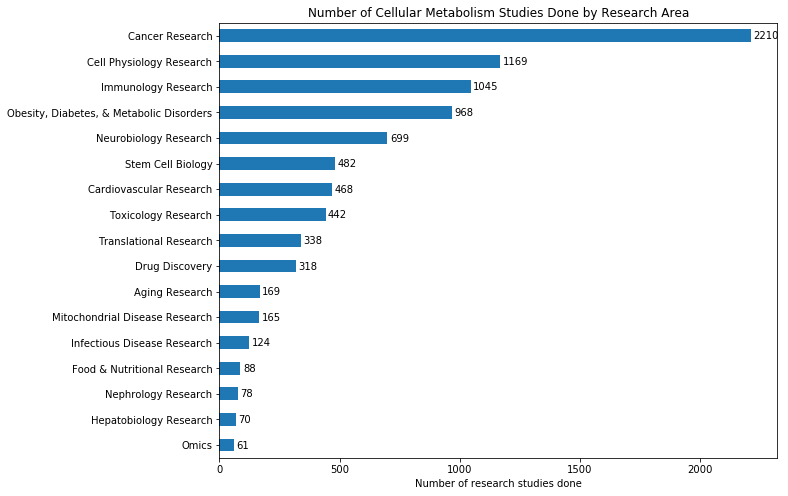

In [366]:
# Remove research areas that have a low value count
# Reference: https://stackoverflow.com/questions/32511061/remove-low-frequency-values-from-pandas-dataframe
threshold = 60 # Anything that occurs less than this will be removed.
value_counts = data['Research area'].value_counts() 
to_remove = value_counts[value_counts <= threshold].index
data['Research area'].replace(to_remove, np.nan, inplace=True)

# Remove research area that is not significant for our purposes
data['Research area'].replace("Techniques & Methods", np.nan, inplace=True)
data['Research area'].replace("Modulation", np.nan, inplace=True)
data['Research area'].replace("Model Organisms", np.nan, inplace=True)
data['Research area'].replace("Cell Metabolism in Technology", np.nan, inplace=True)
data['Research area'].replace("Review Paper", np.nan, inplace=True)

# Plot horizontal bar graph in descending order of the object value counts
plot1 = data['Research area'].value_counts().plot(kind='barh', figsize=(10,8), title='Number of Cellular Metabolism Studies Done by Research Area')
plot1.invert_yaxis()

# Add title, x- and y- axes labels
plot1.set_xlabel("Number of research studies done")
# plot1.set_ylabel("Research area")

# Set individual bar labels
for i in plot1.patches:
    # get_width pulls left or right; get_y pushes up or down
    plot1.text(i.get_width()+10.0, i.get_y()+.38, str(i.get_width()))

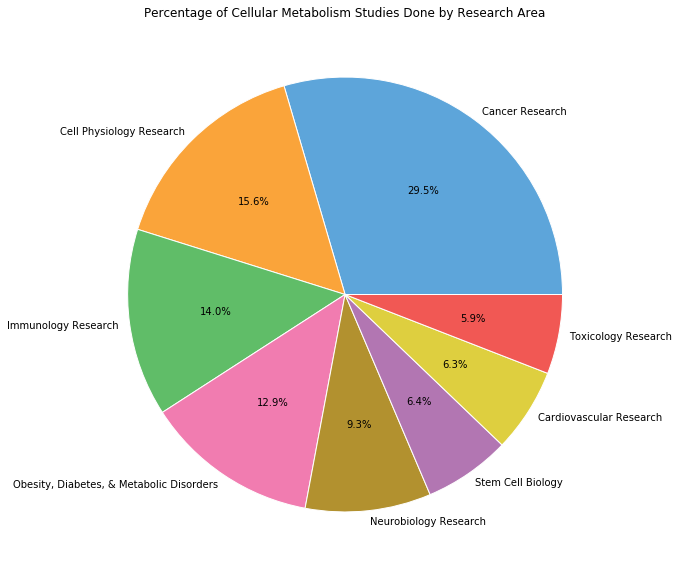

In [367]:
# Pie chart
top_8 = data['Research area'].value_counts()[:8]
Research = top_8.index.tolist()
Occurrence = top_8.values.tolist()

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)

colors = ['#5DA5DA','#FAA43A','#60BD68','#F17CB0','#B2912F','#B276B2','#DECF3F','#F15854']

pie_wedge_collection = ax.pie(Occurrence, colors=colors, labels=Research, autopct='%.1f%%', labeldistance=1.05);

for pie_wedge in pie_wedge_collection[0]:
    pie_wedge.set_edgecolor('white')

ax.set_title("Percentage of Cellular Metabolism Studies Done by Research Area");

# pie = data['Research area'].value_counts()[:8].plot(kind='pie', figsize=(8,8), title='Number of Cellular Metabolism Studies Done by Research Area')

From the data shown, it seems that cellular metabolism has generated the most interest in recent years in the field of cancer research.

### 2. What is the Recent Trend for Cellular Metabolism Studies?

Since the publication date column data, like the other columns, are objects, they need to be converted to datetime so that pandas can plot all data points in the chronological order.

In [368]:
# Format of the publication date data is 'Oct 1 2014 12:00 AM', slice based on space separation
data['Publication date'] = data['Publication date'].astype(str)
data['Publication year'] = data['Publication date'].str.split(' ', n=4, expand = True)[2]
data = data.drop(columns='Publication date')
data.head()

,Title,Authors,Journal,Research area,Cell Line,Cell Type,Species,Analyzer,XF Assay,Plate Reader Assay,Seeding density,Plate coating,Epoch,Publication year
0,_-1-Antitrypsin (AAT)-modified donor cells sup...,"Marcondes AM, Karoopongse E, Lesnikova M, Marg...",Blood,Immunology Research,T-cells,T-cells,Mouse,24,Cell Mitochondrial Stress Test,NaN,8.0x10^5 cells/well,Not Specified,1412121600000000000,2014
1,_-1-Antitrypsin (AAT)-modified donor cells sup...,"Marcondes AM, Karoopongse E, Lesnikova M, Marg...",Blood,Immunology Research,Natural Killer (NK) cells,Immune Cells,Mouse,24,Cell Mitochondrial Stress Test,NaN,8.0x10^5 cells/well,Not Specified,1412121600000000000,2014
2,_-enolase regulates the malignant phenotype of...,"J. Dai, Q. Zhou, J. Chen, M. L. Rexius-Hall, J...",Nat Commun,Cell Physiology Research,Pulmonary Artery Smooth Muscle Cells (PASMC),Pulmonary Artery Cells,Human,24,Cell Mitochondrial Stress Test,NaN,3.0 x10^4 cells/well,Not Specified,1537488000000000000,2018
3,_-enolase regulates the malignant phenotype of...,"J. Dai, Q. Zhou, J. Chen, M. L. Rexius-Hall, J...",Nat Commun,Cell Physiology Research,Pulmonary Artery Smooth Muscle Cells (PASMC),Pulmonary Artery Cells,Human,24,Glycolysis Stress Test,NaN,3.0 x10^4 cells/well,Not Specified,1537488000000000000,2018
4,_-ketoglutarate orchestrates macrophage activa...,"P. S. Liu, H. Wang, X. Li, T. Chao, T. Teav, S...",Nat Immunol,Immunology Research,Bone Marrow-Derived Macrophages (BMDM),Immune Cells,Mouse,96,Cell Mitochondrial Stress Test,NaN,1.0 x10^5 cells/well,Not Specified,1504224000000000000,2017


In [369]:
# convert the 'Publication date' column to datetime format 
data['Publication year'] = pd.to_datetime(data['Publication year'], format='%Y') 

# Check the format of 'Date' column 
# data.info() 
data['Publication year'].value_counts().sort_index()

2009-01-01       2
2010-01-01      12
2011-01-01      36
2012-01-01     101
2013-01-01     465
2014-01-01    1168
2015-01-01    1478
2016-01-01    1255
2017-01-01    2721
2018-01-01    2390
Name: Publication year, dtype: int64

Text(0, 0.5, 'Studies Published')

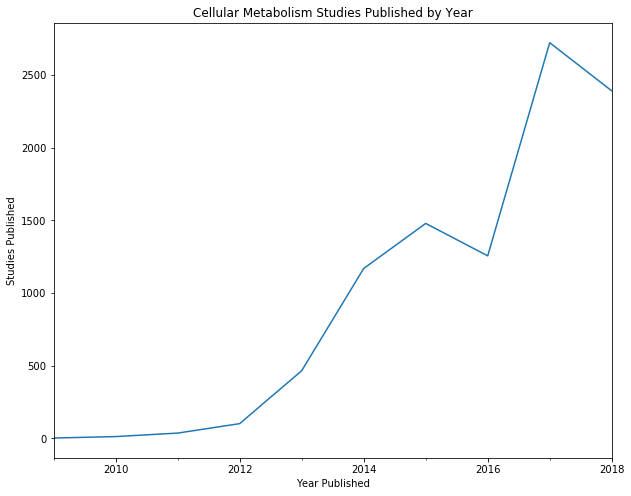

In [370]:
# df_sorted_by_date = data.sort_values(by=['Publication year'])
# plot2 = df_sorted_by_date['Publication year'].value_counts().sort_index().plot(figsize=(10,8), title='Cellular Metabolism Studies Published by Year')
plot2 = data['Publication year'].value_counts().sort_index().plot(figsize=(10,8), title='Cellular Metabolism Studies Published by Year')

# Add x- and y- axes labels
plot2.set_xlabel("Year Published")
plot2.set_ylabel("Studies Published")

As shown in the line graph, there is a significant increase in cellular metabolism studies done since 2013, demonstrating a market need for more cellular metabolism insights.

### 3. What Are the Most Investigated Cell Types?

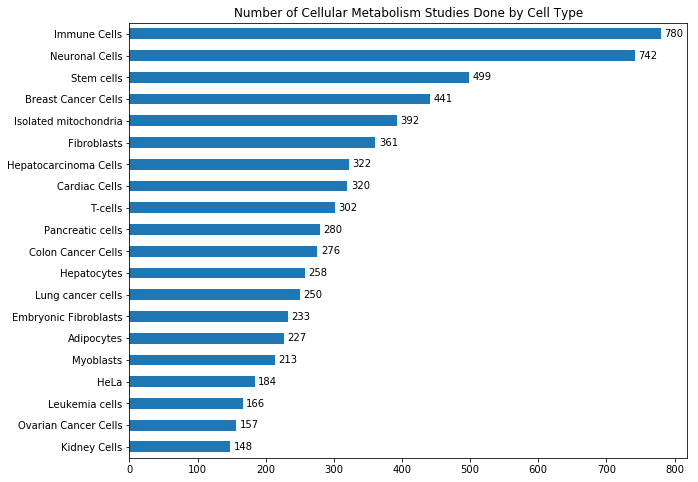

In [371]:
# Look at top 20 most researched cell lines
plot3 = data['Cell Type'].value_counts()[:20].plot(kind='barh', figsize=(10,8), title='Number of Cellular Metabolism Studies Done by Cell Type')
plot3.invert_yaxis()

# set individual bar labels using above list
for i in plot3.patches:
    # get_width pulls left or right; get_y pushes up or down
    plot3.text(i.get_width()+5.0, i.get_y()+.38, str(i.get_width()))

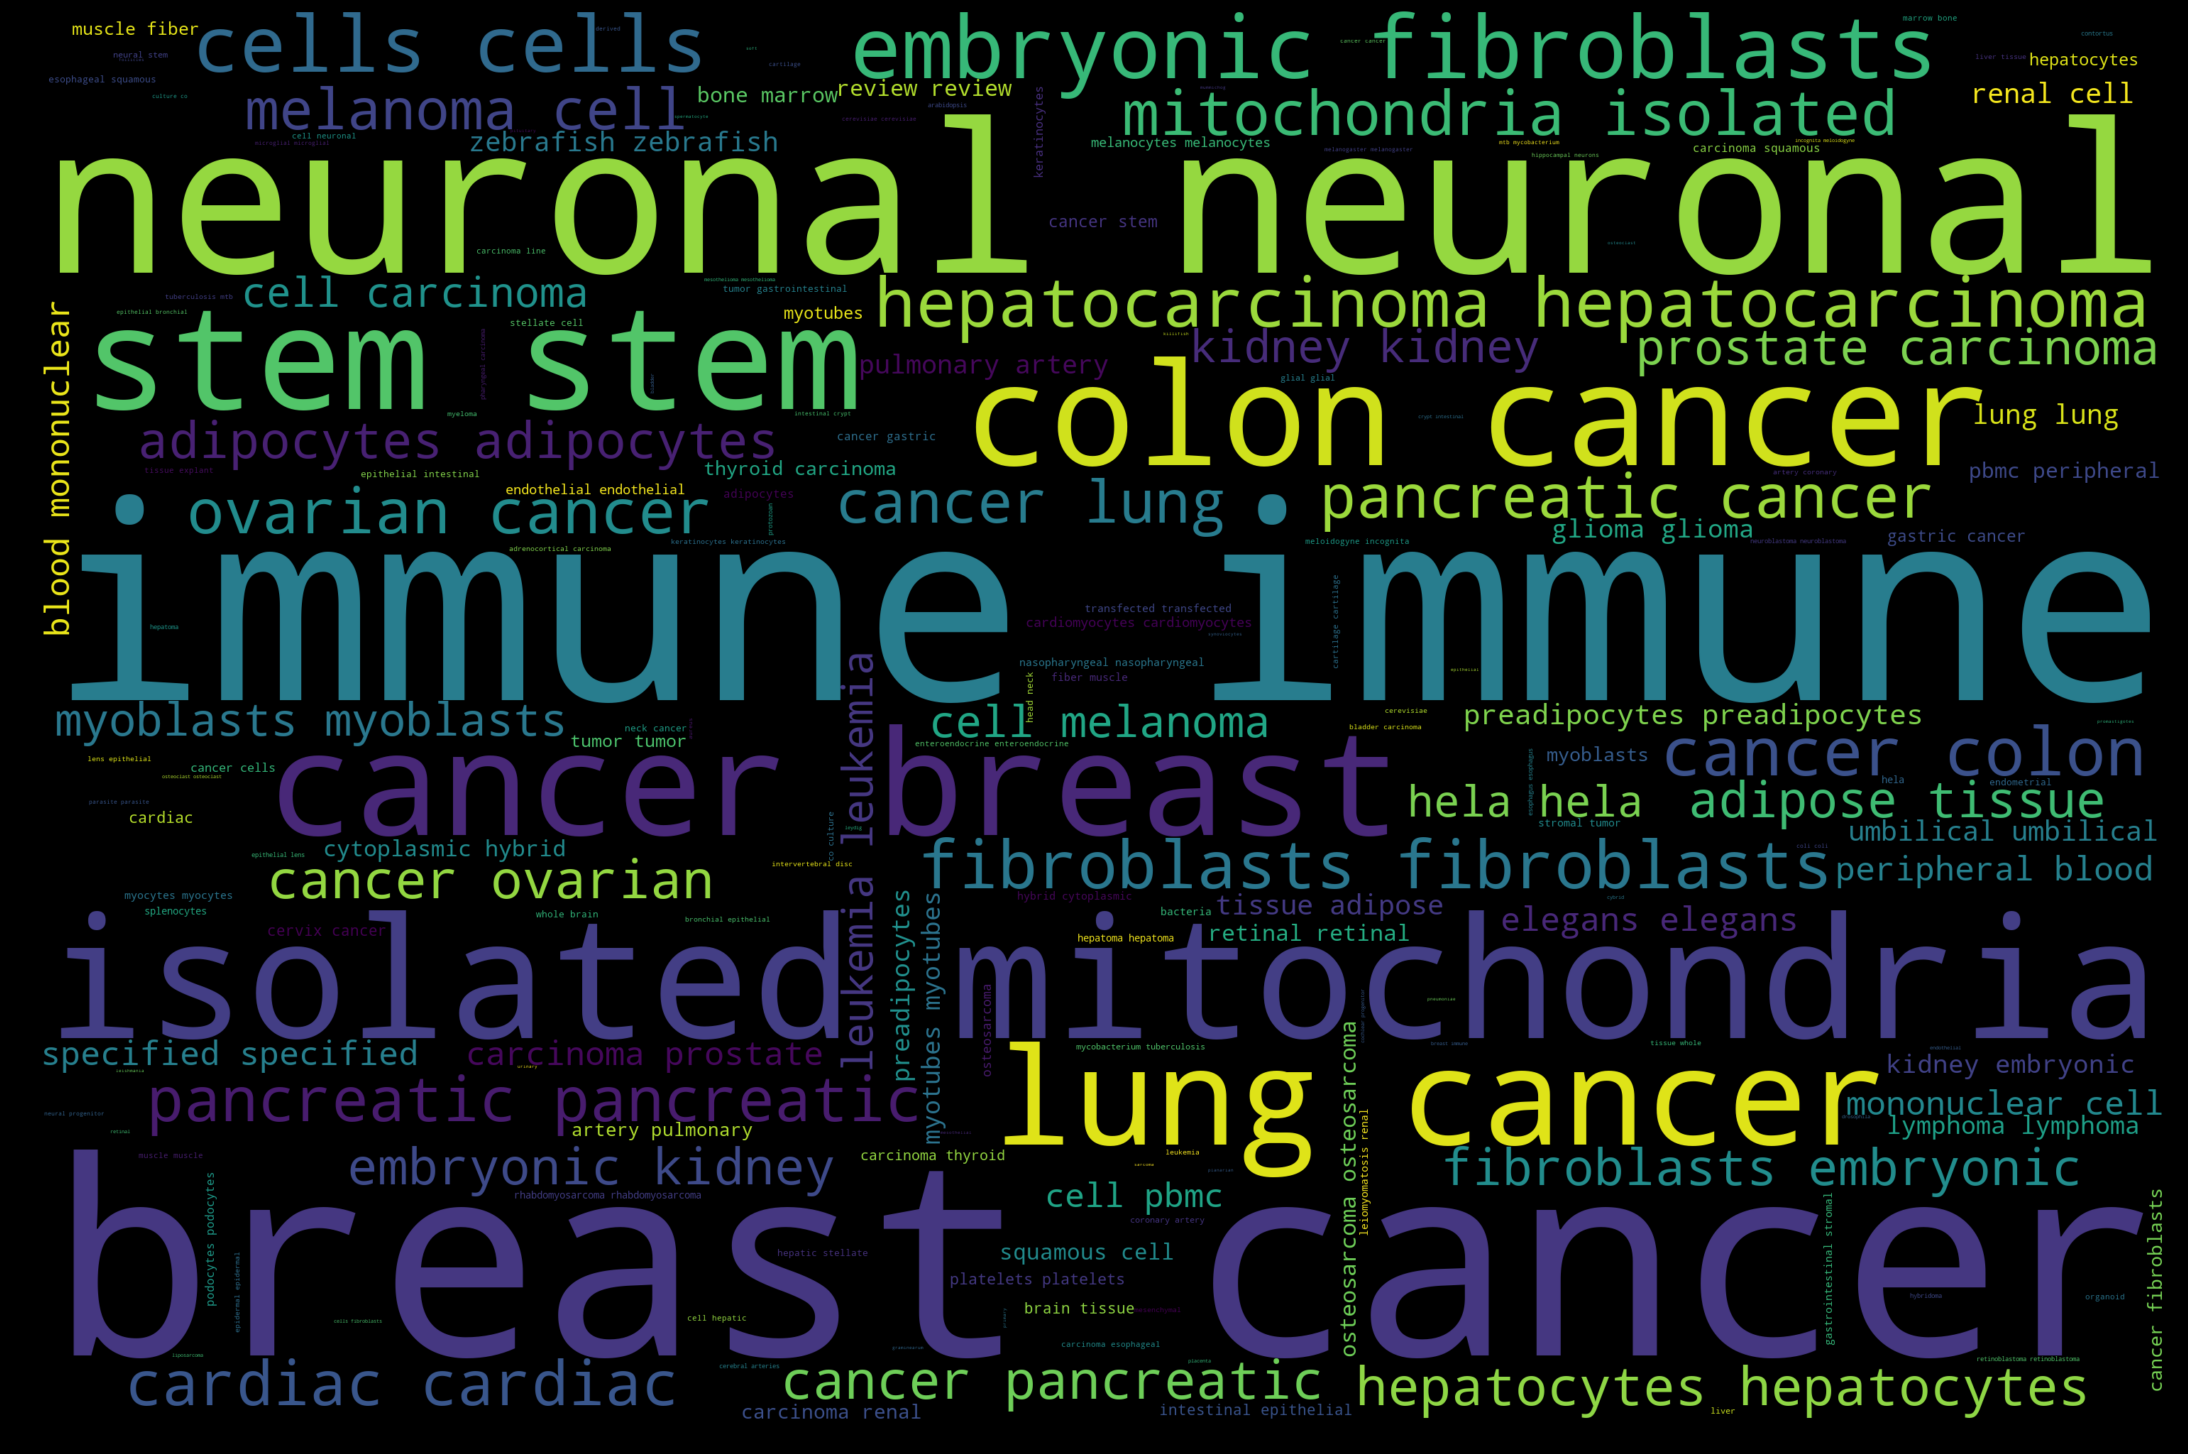

In [372]:
# data['Cell Type'] = data['Cell Type'].astype(str)
# data['Cell Type'] = data['Cell Type'].str.split(' ')

# # Convert a column of lists to a column of strings
# # Reference: https://stackoverflow.com/questions/45306988/column-of-lists-convert-list-to-string-as-a-new-column
# data['Cell Type'] = data['Cell Type'].apply(lambda x: ' '.join(map(str, x)))
data['Cell Type'] = data['Cell Type'].str.lower()

# # Ignore ',cells' from wordcloud
data['Cell Type'] = data['Cell Type'].str.replace(' cells' , '')
text = data['Cell Type'].str.cat(sep=' ')

# Generate word cloud for most researched cell types
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(text)
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Future effort should include looking at how to generate a phrases cloud rather than a word cloud since phrases cloud would be more meaningful.

### 4. Metabolic assays (Work in Progress)

Here we look at which of our competitor's metabolic assays are the most popular

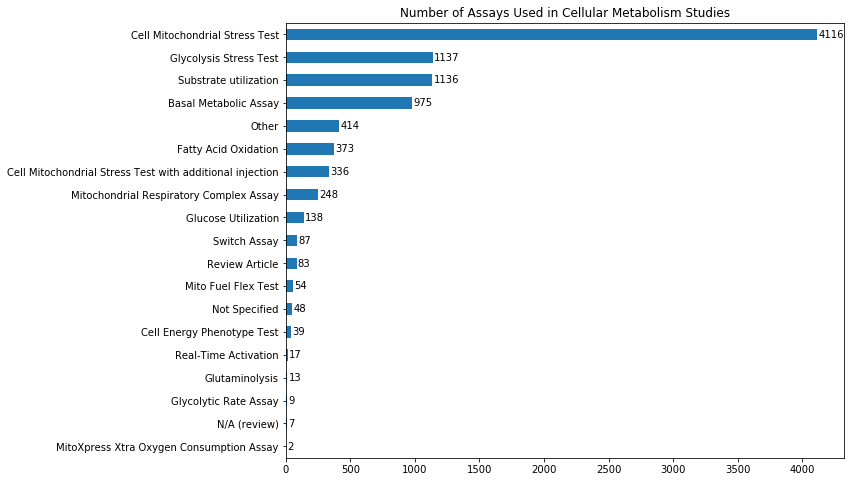

In [376]:
plot4 = data['XF Assay'].value_counts().plot(kind='barh', figsize=(10,8), title='Number of Assays Used in Cellular Metabolism Studies')
plot4.invert_yaxis()

# # create a list to collect the plt.patches data
# totals4 = []

# # find the values and append to list
# for i in plot1.patches:
#     totals4.append(i.get_width())

# # set individual bar lables using above list
# total4 = sum(totals4)

# set individual bar lables using above list
for i in plot4.patches:
    # get_width pulls left or right; get_y pushes up or down
    plot4.text(i.get_width()+10.0, i.get_y()+.38, str(i.get_width()))

**Cell Mitochondrial Stress Test**: measures basal respiration, ATP-linked respiration, H+ (Proton) leak, maximal respiration, spare respiratory capacity, and non-mitochondrial respiration using modulators of cellular respiration.

**Glycolysis Stress Test**: measures basal glycolysis and glycolysis capacity upon blockage of mitochondrial ATP production using respiratory modulators. Non-glycolytic acidification is assessed through glucose starvation.

**Substrate Utilization**

**Basal Metabolic Assay**

**Fatty Acid Oxidation**

**Mitochondrial Respiratory Complex Assay**

**Glucose Utilization**

**Switch Assay**

**Mito Fuel Flex Test**

**Cell Energy Phenotype Test**

**Real-Time Activation**

**Glutaminolysis**

**Glycolytic Rate Assay**

**MitoXpress Xtra Oxygen Consumption Assay**

### 5. Analyzer (Work in Progress)

In [374]:
df.Analyzer.value_counts()

24                        4774
96                        3547
Xfp                        389
Plate Reader               319
Not Specified              318
24-Mar                     164
N/A (Review)                80
Plate Reader 384            21
All Microplate Readers       3
Name: Analyzer, dtype: int64

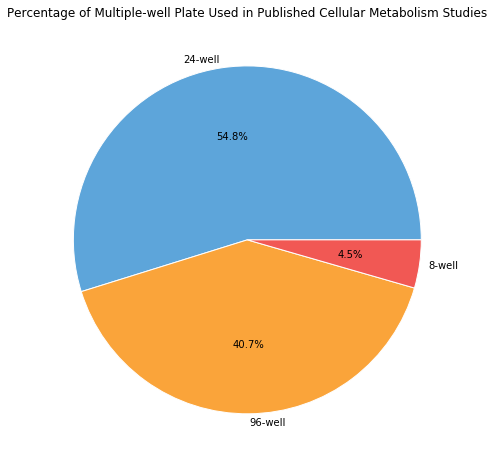

In [375]:
# Xfp assays are done on 8-well plate, replace to reflect the info
df.Analyzer.replace('Xfp', '8-well', inplace=True)
df.Analyzer.replace('24', '24-well', inplace=True)
df.Analyzer.replace('96', '96-well', inplace=True)

# Pie chart
plates = df.Analyzer.value_counts()[:3]
plate_type = plates.index.tolist()
plate_utilization = plates.values.tolist()

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111)

colors = ['#5DA5DA','#FAA43A','#F15854']

pie_wedge_collection = ax.pie(plate_utilization, colors=colors, labels=plate_type, autopct='%.1f%%', labeldistance=1.05);

for pie_wedge in pie_wedge_collection[0]:
    pie_wedge.set_edgecolor('white')

ax.set_title("Percentage of Multiple-well Plate Used in Published Cellular Metabolism Studies");